In [1]:
include("examplesalex/stages.jl")
include("examplesalex/measurement.jl")
include("examplesalex/plot.jl")


correctPosition (generic function with 1 method)

In the following cell the connection between the four motors and the computer is made. Each motor is assigned a name and sorted. The motors whcich are not in use for this measurement are disconnected again.

In [2]:
### Connect to the Motor "Bigger Chungus" ###
devcount, devenum, enumnames = setupDevices(ENUMERATE_PROBE | ENUMERATE_NETWORK,b"addr=134.61.12.184")

D = openDevices(enumnames,stagenames)
checkOrdering(D,stagenames)
closeDevices(D[1:2])


Device count: 4


 D | Name                             | Serial   | Port     | Stage           


 1 | xi-net://134.61.12.184/0000469F  | 18079    | Axis 1   | Big Chungus     
 2 | xi-net://134.61.12.184/00007C52  | 31826    | Axis 2   | Bigger Chungus  
 3 | xi-net://134.61.12.184/00007C40  | 31808    | Axis 1   | Alexanderson    
 4 | xi-net://134.61.12.184/000046A8  | 18088    | Axis 2   | Monica          


  D | Stage names      


  1 | Monica           


  2 | Alexanderson     


  3 | Big Chungus      


  4 | Bigger Chungus   


2-element Vector{Int32}:
 0
 0

The next step is to choose the basic settings of the VNA and connect it also to the computer. 
InstrumentSimplifiedSetup sets the instrument according to the selected settings.
A name for the measurement is also picked.
The parameter vNum represents the number of vertical movements and in a way decides the resolution of the image.
I will change the programm so that the entire mirror is scanned but the vNum results in a higher resolution




In [3]:

#Basic VNA settings
power=-20
f_center::Float64 = 20e9
f_span::Float64 = 3e9
sweepPoints::Integer = 128
ifbandwidth::Integer = 100e3
measurement::String = "CH1_S11_1"

#Number of vertical steps & type of the bead 
vNum = 1

name::String = "2D_CristalRB3-07_SNR_P0"

motorSet = 1            #1 Dominik ist nicht da  2 Dominik ist da

#Connect to the VNA and start basics setup
vna = connectVNA()
vnaParam = instrumentSimplifiedSetup(vna; calName=cals[:c3GHz_NEW], power=power, center=f_center, span=f_span, sweepPoints=sweepPoints, ifbandwidth=ifbandwidth)


VNAParameters("{2D2A1B51-D3C2-4613-98CC-884561BE4A57}", -20, 2.0e10, 3.0e9, 100000, 128, 0.00092928, true)

Now everything is ready to start a scan. The twoDMeasurement function tells the motors how to move, decides when to take the measurements, saves the data on variables and counts the time the entire processes needs. 

In [ ]:

@time S, f, pos_BIGGER, pos_BIG, posSet = twoDMeasurement(vna, 0, 18000; speed=2000, speedSetup=2000, stepSize=500, vNum=vNum, sweepPoints=sweepPoints, motorSet=motorSet)

meas = Measurement2D("", vnaParam, f, S, pos_BIGGER, pos_BIG, posSet)
saveMeasurement(meas; name=name)

closeDevices(D)


Now the saved data can be acessed through the readMeasurment function and visualised with the plot... functions. 
For a better visual idea of the evolution of the beam all pictures a put into a gif. 

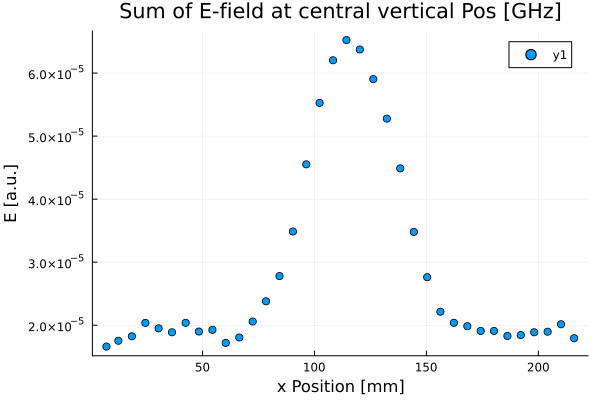

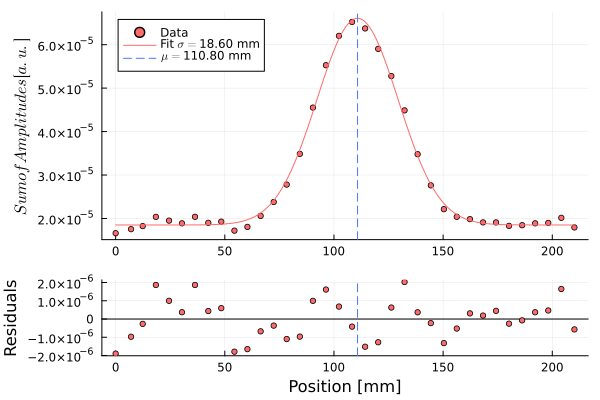

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


UndefVarError: UndefVarError: i not defined

In [6]:

data = readMeasurement("//inst3/data/Benutzer/deslis/Desktop/Hiwi-Job/Data/2D_CristalRB3-07_SNR_P0_2023-06-06_1.jld2")

transData = transform(data,sweepPoints,vNum)

plotPoints(data, sweepPoints, vNum, transData)
plotGaussianFit2D(data, sweepPoints, transData)


anim = @animate for freqIndex in 1:sweepPoints	
    plotHeatmap2D(data, freqIndex)
    println(freqIndex)
    
end
gif(anim, "anim_"*name*".gif", fps = 10)



In [7]:

closeDevices(D)

4-element Vector{Int32}:
 -1
 -1
  0
  0

The next program allows for a easy signal to noise comparisson 

In [ ]:

powerStep = [-20, -15, -10, -5, 0, 5, 10, 14]    
bead = "CristalRB3-07"
date = "2023-07-12"

global vna = connectVNA()
i=1
power= powerStep[i]
println(power)
f_center::Float64 = 20e9
f_span::Float64 = 3e9
sweepPoints::Integer = 128
ifbandwidth::Integer = 100e3
#measurement::String = "CH1_S11_1"

name::String = bead*"_SNR_P"* string(powerStep[i])
println(name)

println("Klappt bis hier")
vnaParam = instrumentSimplifiedSetup(vna; calName=cals[:c3GHz_NEW], power=power, center=f_center, span=f_span, sweepPoints=sweepPoints, ifbandwidth=ifbandwidth)

println("power umstellen klappt")



@time S, f, pos, posSet = getContinousMeasurement(vna, 0, 18000; speed=2000, speedSetup=2000, stepSize=500)
meas = Measurement("", vnaParam, f, S, pos, posSet)
saveMeasurement(meas; name= "/inst3/data/Benutzer/deslis/Desktop/Hiwi-Job/"*name*".jld2")
    
disconnectVNA(vna)
@time S, f, pos, posSet = getContinousMeasurement(vna, 0, 18000; speed=2000, speedSetup=2000, stepSize=500)